In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

## Loading and averaging weights

In [3]:
# Loading wieghts
N=1500
coarse=6
var = 'tos'
directory = '../weights/'
if var == 'pr':
    file = 'Anchor_OPLS_{}_weights_stability_n{}_coarse{}.pkl'.format('precip', N, coarse)
elif var == 'tas' :
    file = 'Anchor_OPLS_{}_weights_stability_n{}_coarse{}.pkl'.format(var, 600, coarse)
else :
    file = 'Anchor_OPLS_{}_weights_stability_n{}_coarse{}.pkl'.format(var, N, coarse)
with open(directory + file, 'rb') as f:
    weights = pickle.load(f)

In [4]:
# Averaging training weights
gamma = 5 # Possible gamma : {2, 5, 10}
total_weights = np.zeros(weights['CanESM5'][gamma]['weights'].shape)
total_samples = 0
for model in models:
    total_weights += weights[model][gamma]['weights']*weights[model][gamma]['n_samples']
    total_samples += weights[model][gamma]['n_samples']
total_weights /= total_samples

In [5]:
file

'Anchor_OPLS_tos_weights_stability_n1500_coarse6.pkl'

In [6]:
total_weights

array([[ 1.16161687e-04,  1.71197903e-04,  1.23007736e-04, ...,
        -5.33256981e-05, -5.20696799e-05, -5.11099073e-05],
       [-1.09251163e-04, -1.75408504e-04, -1.29457831e-04, ...,
        -3.78102085e-05, -3.36620124e-05, -3.17034605e-05],
       [-4.54430259e-05,  5.36968805e-05, -7.02835152e-05, ...,
        -7.38875272e-05, -7.60830965e-05, -7.77123677e-05],
       ...,
       [ 1.11714505e-04,  3.44452055e-04, -2.22101784e-06, ...,
         1.32733793e-03,  1.31957640e-03,  1.31077099e-03],
       [-3.01355176e-04,  2.73707198e-04, -5.15443070e-04, ...,
         5.34831524e-04,  5.39441542e-04,  5.33213655e-04],
       [-1.05432580e-03,  1.14003025e-03,  5.67354091e-05, ...,
         1.30821990e-03,  1.34143498e-03,  1.34164394e-03]])

## Predictions

In [7]:
path='../data/Evaluation-Tier1/Omon/{}'.format(var)
path2='../predictions/{}'.format(var)

for file in os.listdir(path) :
    # Opening test file 
    file_path = os.path.join(path, file)
    ds = xr.open_dataset(file_path)
    # Compute anomalies
    climatology = ds.groupby('time.month').mean(dim='time')
    anomalies = ds.groupby('time.month') - climatology
    shape = anomalies['tos'].shape
    
    array = anomalies['tos'].values
    # Generate random values from a normal distribution with mean 0 and standard deviation 0.1
    random_values = np.random.normal(loc=0, scale=0.1, size=shape)

    # Replace NaN values with random values
    array[np.isnan(array)] = random_values[np.isnan(array)]
    # Coarsening anomalies
    anomalies_regional = array.reshape(shape[0], shape[1]//coarse, coarse, shape[2]//coarse, coarse)
    X = anomalies_regional.mean(axis=(2, 4)).reshape(shape[0], (shape[1]//coarse) * (shape[2]//coarse))
    
    print(X.shape, total_weights.shape)
    
    # Prediction using reduced rank weight matrix 
    Y_pred = X @ total_weights
    
    
    
    # Reshape to original shape (time, lat, lon)
    Y_pred_spatial = Y_pred.reshape(shape[0], shape[1], shape[2])
    
    
    # Saving data 
    ds['tos'][:] = Y_pred_spatial 
    #ds = ds.groupby('time.month') + climatology
    
    file_path2 = os.path.join(path2, file[:-17] + '_1_anchor_OPLS_UV-ISP.nc')
    ds.to_netcdf(file_path2)
    
    ds.close()

(876, 288) (288, 10368)
(876, 288) (288, 10368)
(876, 288) (288, 10368)
(876, 288) (288, 10368)
(876, 288) (288, 10368)
(876, 288) (288, 10368)
(876, 288) (288, 10368)
(876, 288) (288, 10368)
(876, 288) (288, 10368)
(876, 288) (288, 10368)


## Checking predictions

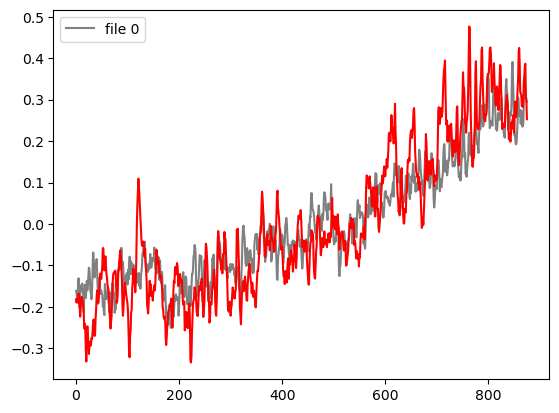

In [11]:
path2='../predictions/{}'.format(var)
i=0
for file in os.listdir(path2)[:1] :
    file_path = os.path.join(path2, file)
    ds = xr.open_dataset(file_path)
    plt.plot(ds['tos'].values.mean(axis=(1, 2)), label='file {}'.format(i), color='grey')
    ds.close()
    i+=1
plt.plot(anomalies['tos'].values.mean(axis=(1,2)), color='red')
plt.legend()
plt.show()